<a href="https://colab.research.google.com/github/devforian/Daycon-XGBoost-CarPricing/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 중고차 가격 예측 경진대회

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 불러오기

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

print(f'{train.shape[1]} 개의 feature, {train.shape[0]} 개의 데이터 샘플로 이루어진 train data set')

train.head()

11 개의 feature, 1015 개의 데이터 샘플로 이루어진 train data set


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


트레인과 테스트 데이터 모양 행과 열

In [ ]:
print(train.shape, test.shape)

(1015, 11) (436, 10)


## 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해야 함

In [ ]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼: {col}')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않음')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않음


## 데이터 전처리

### 오탈자 처리

In [ ]:
train[train['year'] < 1900]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
415,415,Mercedes-Benz ATEGO,403461,Lagos,Locally used,4-cylinder(I4),manual,diesel,white,1218,6015000
827,827,Mercedes-Benz/52,510053,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1217,75015000


위의 year에서 1218, 1217 데이터가 존재

이는 오기입된 데이터라고 판단될 수 있으므로 제거

In [ ]:
train = train[train['year'] > 1980]
train = train.drop('id', axis = 1).reset_index().drop('index', axis = 1).reset_index().rename({'index':'id'}, axis = 'columns')
train.shape

(1012, 11)

### 파생변수 생성

In [ ]:
train['title'].value_counts()[:20]

Toyota Camry            129
Toyota Corolla          108
Toyota Highlander        50
Toyota Sienna            49
Toyota RAV 4             40
Honda Accord             38
Lexus RX 350             33
Lexus ES 350             24
Toyota Venza             16
Lexus GX 460             16
Honda Pilot              15
Lexus LX 570             14
Toyota Avalon            13
Mercedes-Benz ML 350     13
Ford Explorer            12
Mercedes-Benz E 350      12
Mercedes-Benz GL 450     12
Toyota Matrix            12
Toyota 4-Runner          12
Toyota Tacoma            12
Name: title, dtype: int64

In [ ]:
train['brand'] = train['title'].apply(lambda x : x.split(" ")[0])
train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,Toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,Toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,Land
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000,Lexus
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000,Toyota


In [ ]:
print('title의 unique 카테고리 개수 : ', len(train['title'].value_counts()))
print('brand의 unique 카테고리 개수 : ', len(train['brand'].value_counts()))

title의 unique 카테고리 개수 :  200
brand의 unique 카테고리 개수 :  41


### 데이터 정제

In [ ]:
train['paint'].value_counts()[:20]

Black        292
White        115
Silver       103
Grey          84
Blue          70
Red           53
Dark Grey     47
Gold          37
white         23
Green         18
Gray          17
Brown         16
Black         15
Dark Blue     14
Wine           8
Silver         5
Sliver         5
blue           5
red            5
Grey           3
Name: paint, dtype: int64

In [ ]:
import re

def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i])
        review = re.sub(r'\d+','',review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        #review = re.sub(r'l', '', review)
        corpus.append(review)

    return corpus


In [ ]:
print('정제 전 brand의 unique 카테고리 개수 : ', len(train['paint'].unique()))

temp = clean_text(train['paint'])
train['paint'] = temp
temp = clean_text(train['location'])
train['location'] = temp
temp = clean_text(train['isimported'])
train['isimported'] = temp
temp = clean_text(train['transmission'])
train['transmission'] = temp
temp = clean_text(train['fuel'])
train['fuel'] = temp
temp = clean_text(train['brand'])
train['brand'] = temp

print('정제 후 brand의 unique 카테고리 개수 : ', len(train['paint'].unique()))

정제 전 brand의 unique 카테고리 개수 :  76
정제 후 brand의 unique 카테고리 개수 :  51


In [ ]:
train['paint'].value_counts()[:20]

black        310
white        141
silver       109
grey          87
blue          78
red           58
dark grey     48
gold          41
green         20
gray          18
dark blue     17
brown         16
wine           9
sliver         5
dark ash       4
cream          4
ash            3
purple         3
yellow         3
whiteblue      2
Name: paint, dtype: int64

In [ ]:
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

In [ ]:
train['paint'].value_counts()

black     312
grey      159
white     145
silver    117
blue      105
red        60
gold       42
green      21
brown      17
wine       10
ash         8
cream       4
purple      3
yellow      3
milk        2
maroon      2
beige       1
orange      1
Name: paint, dtype: int64

In [ ]:
print('paint의 unique 카테고리 개수 : ', len(train['paint'].value_counts()))

paint의 unique 카테고리 개수 :  18


### 라벨 인코딩

**'Label Encoding'** 을 통해서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩

In [ ]:
#라벨인코딩을 하기 위한 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채움
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

{'title': {'unknown': 0, 'Toyota RAV 4': 1, 'Toyota Land Cruiser': 2, 'Land Rover Range Rover Evoque': 3, 'Lexus ES 350': 4, 'Toyota Venza': 5, 'Toyota Corolla': 6, 'Land Rover Range Rover Sport': 7, 'Pontiac Vibe': 8, 'Toyota Tacoma': 9, 'Lexus RX 350': 10, 'Ford Escape': 11, 'Honda Civic': 12, 'Volvo XC90': 13, 'BMW 750': 14, 'Infiniti JX': 15, 'Honda Accord': 16, 'Mercedes-Benz ML 350': 17, 'Toyota Camry': 18, 'Hyundai Azera': 19, 'Lexus GX 460': 20, 'BMW 325': 21, 'Toyota Sienna': 22, 'Honda Fit': 23, 'Honda CR-V': 24, 'Hyundai Tucson': 25, 'Ford Transit': 26, 'Jaguar XJ8': 27, 'BMW X6': 28, 'Mercedes-Benz C 300': 29, 'Mitsubishi Galant': 30, 'Mercedes-Benz GL 450': 31, 'Lexus RX 300': 32, 'Toyota Highlander': 33, 'Mitsubishi CANTER PICK UP': 34, 'Nissan Titan': 35, 'Lexus IS 250': 36, 'Mercedes-Benz 200': 37, 'Toyota Sequoia': 38, 'Ford Explorer': 39, 'Hyundai ix35': 40, 'Mack CH613 CONVENTIONAL CAB': 41, 'Lexus CT 200h': 42, 'Lexus LX 570': 43, 'Toyota Avensis': 44, 'Toyota 4-Run

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,1,18277,1,1,1,1,1,1,2016,13665000,1
1,1,2,10,1,2,1,1,1,2,2019,33015000,1
2,2,3,83091,1,1,2,1,1,1,2012,9915000,2
3,3,4,91524,1,1,1,1,1,3,2007,3815000,3
4,4,5,94177,1,1,2,1,1,1,2010,7385000,1


## 모델링

### 변수 정의

데이터를 독립변수(X)와 종속변수(y) 로 나눔

X: 가격을 제외한 중고차 시장 데이터

y: 중고차 가격(target)

In [ ]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 중고차 가격 추출

In [ ]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.3) #30프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (708, 12)
검증할 val 셋 :  (304, 12)


**759개의 데이터를 학습**시켜

**254개의 데이터로 성능을 검증**

In [ ]:
train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 target 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #validation 데이터에서 target 추출

data_X = data.drop(['target'], axis = 1)
data_y = data.target

print(val_data_X.shape)
print(val_data_y.shape)

print(data_X.shape)
print(data_y.shape)

print(data_X[:5])
print(data_y[:5])

(304, 10)
(304,)
(1012, 10)
(1012,)
   title  odometer  location  isimported  engine  transmission  fuel  paint  \
0      1     18277         1           1       1             1     1      1   
1      2        10         1           2       1             1     1      2   
2      3     83091         1           1       2             1     1      1   
3      4     91524         1           1       1             1     1      3   
4      5     94177         1           1       2             1     1      1   

   year  brand  
0  2016      1  
1  2019      1  
2  2012      2  
3  2007      3  
4  2010      1  
0    13665000
1    33015000
2     9915000
3     3815000
4     7385000
Name: target, dtype: int64


## XGBoost model

In [ ]:
import xgboost

xgb_model = xgboost.XGBRegressor(objective='reg:squarederror',
                                 colsample_bytree = 0.5,
                                 learning_rate = 0.1,
                                 max_depth = 5,
                                 alpha = 20,
                                 n_estimators = 1000)

xgb_model.fit(train_data_X,train_data_y)

XGBRegressor(alpha=20, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [ ]:
pred = xgb_model.predict(val_data_X)

pred = pred.ravel()

In [ ]:
import numpy as np

li = [0.5, 0.5];
li = np.array(li)
li.shape

(2,)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))

    return score

y_hat = xgb_model.predict(val_data_X) # y예측
y_hat = y_hat.ravel()
print(f'오차율: {nmae(val_data_y,y_hat)}')

오차율: 0.36324900717677255


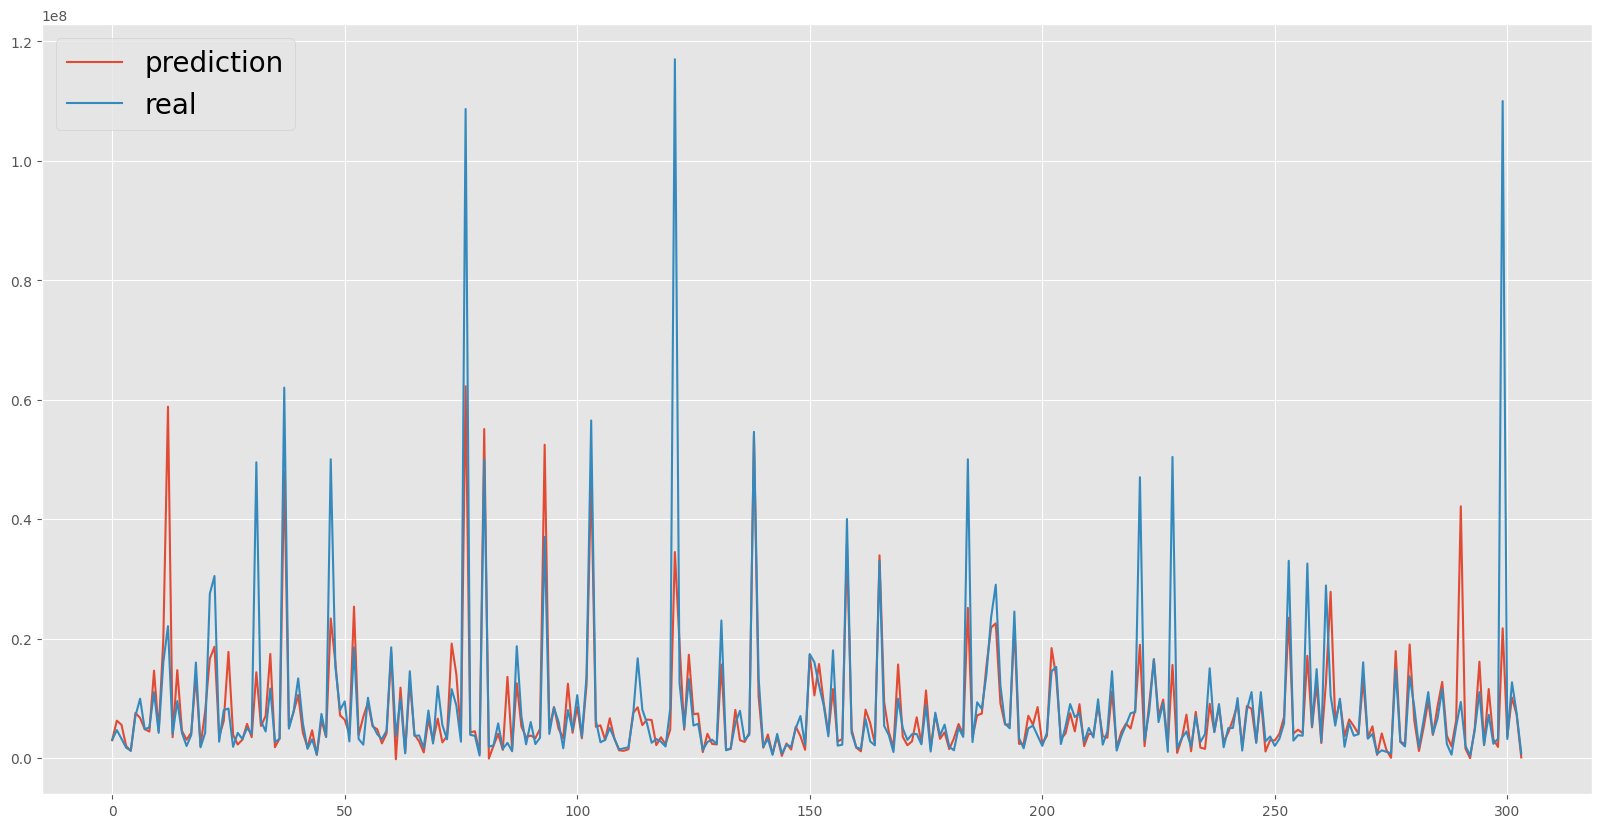

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

파란선: 실제 target 값

붉은 선: 모델이 예측한 값

In [ ]:
check_missing_col(test) # 결측치 확인

test = test.drop('id', axis = 1) #분석에 필요없는 열 삭제

test['brand'] = test['title'].apply(lambda x : x.split(" ")[0])

temp = clean_text(test['paint']) #메소드 적용
test['paint'] = temp
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

test = label_encoder(test, le)

결측치가 존재하지 않음


In [ ]:
xgb_model.fit(X, y)

XGBRegressor(alpha=20, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [ ]:
y_pred = xgb_model.predict(test)
y_pred[0:5]

array([13632278. ,  3869019.8,  6301588. ,  1512186.8,  2287195.8],
      dtype=float32)

## Dacon 대회에 제출하기 (Submission)


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
submission['target'] = y_pred

submission.head()

,id,target
0,0,13632278.00
1,1,3869019.75
2,2,6301588.00
3,3,1512186.75
4,4,2287195.75


In [ ]:
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submit.csv', index=False)